Código desenvolvido para o TCC intitulado "Classificação de Persuasão em Textos de Memes: Uma Abordagem Baseada em Engenharia de Características".

Aluno: Leonardo Souza Gomes de Lima

Orientador: Prof. Eduardo Corrêa Gonçalves

Escola Nacional de Ciências Estatísticas (ENCE/IBGE) - 2024.1

### **Importar Bibliotecas**

In [ ]:
!pip install xlsxwriter
!pip install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import spacy
nlp = spacy.load('en_core_web_sm')
import string
nltk.download('punkt')
from wordcloud import WordCloud # Nuvem de palavras
import matplotlib.pyplot as plt # Plotar
from sklearn import tree # Árvore de decisão
from sklearn.ensemble import RandomForestClassifier # Random Forest - classificador
from sklearn.linear_model import LogisticRegression # Regressão Logística
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix # Matriz de confusão
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # Acurácia, Precisão, Recall, F1-Score
import time # Operações de tempo
from datetime import datetime # Operações de tempo
import pytz # Fuso horário brasileiro
from openpyxl import load_workbook
from openpyxl.styles import PatternFill # Formatar saída Excel
import xlsxwriter # Excel
import textstat # Estatísticas textuais
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
import re # Expressões Regulares
import statsmodels.api as sm # Biblioteca estatística
from imblearn.under_sampling import RandomUnderSampler # Undersampling
from imblearn.over_sampling import SMOTE # SMOTE
import imblearn
from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### **Carregar Base de Dados**

In [ ]:
#@markdown **Selecionar base a ser carregada:**
base = "Treino" #@param ["Treino", "Validacao", "Teste"]

# Carrega a base selecionada:
if base == "Treino":
  treino_url = r'https://drive.google.com/uc?export=download&id=1TbRHIBkFBSdeAUj8CIB7H4KHlmDZ_qu-'
  df = pd.read_excel(treino_url)

if base == "Validacao":
  validacao_url = r'https://drive.google.com/uc?export=download&id=1_SzAKCFq1RKGtaNjZEKx21o-OTViRmQU'
  df = pd.read_excel(validacao_url)

if base == "Teste":
  teste_url = r'https://drive.google.com/uc?export=download&id=1Tk34Ma74X9vE_794R20ZzNAugeKSu-tA'
  df = pd.read_excel(teste_url)

pd.set_option('display.max_columns', None)

## **Tratamento da base**

In [ ]:
# Adiciona coluna identificadora de propaganda:
# 0: "não-propaganda"
# 1: "propaganda"

In [ ]:
def definir_propaganda(label):
  if label == True:
    return 0
  else:
    return 1

df['propaganda'] = df['labels/0'].isna().apply(definir_propaganda)

In [ ]:
# Detectar e excluir observações vazias:
if df['text'].isna().sum() == 0:
  print('A base não possui valores NA.')
else:
  print(f'A base possui valores NA. Total de observações vazias: {df["text"].isna().sum()}')

  # Excluindo NAs:
  #df = df[~df['text'].isnull()].reset_index(drop=True)
  df = df.dropna(subset=['text']).reset_index(drop=True)

  print('Observações NA removidas com sucesso!')

A base possui valores NA. Total de observações vazias: 1
Observações NA removidas com sucesso!


In [ ]:
# Criar coluna auxiliar sem 'enter' no texto dos memes:
df['text_sem_enter'] = None
for meme_enter in range(len(df)):
  try:
    df.at[meme_enter, 'text_sem_enter'] = df.at[meme_enter, 'text'].replace('\\n', ' ')
  except:
    print(meme_enter)

# Criar coluna com tokens das frases:
def tokenizar_meme(texto):
  return nltk.sent_tokenize(texto)

df['frases_tokens'] = df['text_sem_enter'].apply(tokenizar_meme)

In [ ]:
# Contabilizando quantos memes possuem espaços múltiplos no seu texto:
def contar_textos_com_espacos_multiplos(df, coluna):
    # Inicializar contador
    contador = 0

    # Iterar sobre cada texto na coluna do DataFrame
    for texto in df[coluna]:
        # Verificar se o texto possui espaços múltiplos
        if '  ' in texto:
            contador += 1

    return contador

print(f"Número de textos com espaços múltiplos: {contar_textos_com_espacos_multiplos(df, 'text')}")
print(f"{(round(contar_textos_com_espacos_multiplos(df, 'text') / len(df),4)) * 100}% da base possui espaços múltiplos.")

Número de textos com espaços múltiplos: 37
0.53% da base possui espaços múltiplos.


In [ ]:
# Removendo espaços múltiplos e salvando em nova coluna:
def remover_espacos_multiplos(texto):
    texto_sem_espacos_multiplos = ' '.join(texto.split())
    return texto_sem_espacos_multiplos

df['texto_processado'] = df['text_sem_enter'].apply(remover_espacos_multiplos)

In [ ]:
# Criando coluna com texto processado lematizado:
def lematizar_texto(texto):
  # Processa texto em inglês com spacy:
  doc = nlp(texto)

  # Texto lematizado:
  texto_lematizado = ' '.join([token.lemma_ for token in doc])

  return texto_lematizado

df['texto_lematizado'] = df['texto_processado'].apply(lematizar_texto)

# Criando coluna com texto sem stopwords:
def remover_stopwords(texto):
  # Aplicar o processamento de texto usando spaCy
  doc = nlp(texto)
  # Filtrar as palavras que não são stopwords e concatenar em uma única string
  texto_sem_stopwords = ' '.join([token.text for token in doc if not token.is_stop])
  return texto_sem_stopwords

df['texto_sem_stopwords'] = df['texto_lematizado'].apply(remover_stopwords)

In [ ]:
#@markdown **Selecione o modelo a ser treinado:**
classificacao = "Simples" #@param ["Multirrotulo", "Simples"]

if classificacao == 'Multirrotulo':
  # Trocanco valores nan por 'vazio':
  df = df.fillna(value='vazio')

  # Salvando técnicas de persuasão em lista:
  tecnicas = list(set(list(df['labels/0'])))
  tecnicas = sorted(filter(lambda x: not pd.isna(x), tecnicas))

  # Selecionar apenas as colunas 'labels/0', 'labels/1', 'labels/2', etc.
  labels_columns = [col for col in df.columns if col.startswith('labels/')]

  # Criar a coluna 'labels' com os dados das colunas selecionadas
  df['labels'] = df[labels_columns].apply(lambda row: row.tolist(), axis=1)

  # Remover 'vazio':
  def remove_empty_values(lista):
    return [x for x in lista if x != 'vazio']

  tecnicas = remove_empty_values(tecnicas)
  df['labels'] = df['labels'].apply(remove_empty_values)

  # Contar total de labels:
  def total_labels(lista):
    return len(lista)

  df['tot_labels'] = df['labels'].apply(total_labels)

  # Iterar sobre a lista de técnicas e inserir novas colunas no DataFrame
  for tecnica in tecnicas:
    df.insert(len(df.columns), tecnica, None)  # Insere uma nova coluna com o nome da técnica


else:
  df = df[['id', 'text', 'text_sem_enter', 'texto_processado',
           'texto_lematizado', 'texto_sem_stopwords',
           'frases_tokens', 'propaganda']]

display(df.head())

,id,text,text_sem_enter,texto_processado,texto_lematizado,texto_sem_stopwords,frases_tokens,propaganda
0,65635,THIS IS WHY YOU NEED\n\nA SHARPIE WITH YOU AT ...,THIS IS WHY YOU NEED A SHARPIE WITH YOU AT AL...,THIS IS WHY YOU NEED A SHARPIE WITH YOU AT ALL...,this be why you need a SHARPIE with you at all...,need SHARPIE time,[THIS IS WHY YOU NEED A SHARPIE WITH YOU AT A...,1
1,67927,GOOD NEWS!\n\nNAZANIN ZAGHARI-RATCLIFFE AND AN...,GOOD NEWS! NAZANIN ZAGHARI-RATCLIFFE AND ANOO...,GOOD NEWS! NAZANIN ZAGHARI-RATCLIFFE AND ANOOS...,good news ! NAZANIN ZAGHARI - RATCLIFFE and AN...,good news ! NAZANIN ZAGHARI - RATCLIFFE ANOOSH...,"[GOOD NEWS!, NAZANIN ZAGHARI-RATCLIFFE AND ANO...",1
2,68031,PAING PHYO MIN IS FREE!,PAING PHYO MIN IS FREE!,PAING PHYO MIN IS FREE!,pae PHYO MIN be free !,pae PHYO MIN free !,[PAING PHYO MIN IS FREE!],0
3,77490,Move your ships away!\n\noooook\n\nMove your s...,Move your ships away! oooook Move your ships...,Move your ships away! oooook Move your ships a...,move your ship away ! oooook move your ship aw...,"ship away ! oooook ship away ! , add 10","[Move your ships away!, oooook Move your ship...",0
4,67641,"WHEN YOU'RE THE FBI, THEY LET YOU DO IT.","WHEN YOU'RE THE FBI, THEY LET YOU DO IT.","WHEN YOU'RE THE FBI, THEY LET YOU DO IT.","when YOU'RE the FBI , they let you do it .","YOU'RE FBI , let .","[WHEN YOU'RE THE FBI, THEY LET YOU DO IT.]",1


In [ ]:
# @title
if classificacao == 'Multirrotulo':
  colunas_multi = ['id', 'text', 'propaganda', 'text_sem_enter', 'frases_tokens', 'texto_processado', 'labels', 'tot_labels'] + tecnicas
  df = df[colunas_multi]

  # Iterar sobre as linhas do DataFrame
  for index, row in df.iterrows():
      # Iterar sobre os nomes das colunas
      for col_name in row['labels']:
          # Verificar se o nome da coluna está presente na lista
          if col_name in df.columns:
              # Definir o valor como 1
              df.at[index, col_name] = 1

  # Dicionário para armazenar os valores presentes na lista tecnicas e a soma da coluna correspondente
  soma_por_tecnica = {}

  # Iterar sobre as técnicas
  for tecnica in tecnicas:
      # Calcular a soma da coluna correspondente à técnica
      soma = df[tecnica].sum()
      # Adicionar a técnica e a soma ao dicionário
      soma_por_tecnica[tecnica] = soma


#display(df.head())
#print(soma_por_tecnica)

### **Nuvem de Palavras**

In [ ]:
#@markdown  Nuvem de Palavras:
nuvem_palavras = False #@param {type:"boolean"}

if nuvem_palavras:
  def criar_nuvem_palavras(texto):
    # Combina todas as palavras em uma única string
    texto_completo = ' '.join(texto)

    # Cria um objeto WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_completo)

    # Plotar a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


In [ ]:
# Nuvem de palavras da base:
if nuvem_palavras:
 criar_nuvem_palavras(df['texto_sem_stopwords'])

In [ ]:
# Nuvem de palavras - Não-propaganda:
if nuvem_palavras:
  criar_nuvem_palavras(df[df['propaganda'] == 0]['texto_sem_stopwords'])

In [ ]:
# Nuvem de palavras - Propaganda:
if nuvem_palavras:
  criar_nuvem_palavras(df[df['propaganda'] == 1]['texto_sem_stopwords'])

### **Balanceamento da Base**

In [ ]:
#@markdown **Selecionar o balanceamento:**
balanceamento = "Sem Balanceamento" #@param ["Undersampling", "Oversampling", "SMOTE", "Sem Balanceamento"]

if balanceamento == "Undersampling":
  pass

if balanceamento == "Oversampling":
  pass

if balanceamento == "SMOTE":
  pass


### **Engenharia de Features - Vetorizar Textos - Definir Atributos**

A unidade de análise proposta por (CRUZ et al., 2019) é a frase do artigo. Aqui, aplica-se a unidade de análise "meme" no lugar. Portanto, onde se aplica ao meme aqui, se aplicou à frases no artigo original.

De acordo com os memes originais da base, podemos entender o "Enter" como a divisão do texto na imagem (parte superior e parte inferior, por exemplo).

In [ ]:
#@markdown  **Selecione os Atributos:**

#@markdown  Total de Frases (Cruz et al., 2019):
tot_frases = True #@param {type:"boolean"}

#@markdown  Total de Palavras:
tot_palavras = False #@param {type:"boolean"}

#@markdown  Total de "Enters":
tot_enters = False #@param {type:"boolean"}

#@markdown  Média de caracteres por frase do meme (Cruz et al., 2019):
med_caracteres_frase = True #@param {type:"boolean"}

#@markdown  Variância de caracteres por frase do meme (Cruz et al., 2019):
var_caracteres_frase = True #@param {type:"boolean"}

#@markdown  Total de caracteres no meme (Cruz et al., 2019):
tot_caracteres = True #@param {type:"boolean"}

#@markdown  Média de caracteres por palavras (Cruz et al., 2019):
med_caracteres_palavra = True #@param {type:"boolean"}

#@markdown  Variância de caracteres por palavras (Cruz et al., 2019):
var_caracteres_palavra = True #@param {type:"boolean"}

#@markdown  Frequência de pontuação do meme (Cruz et al., 2019):
freq_pontuacao = True #@param {type:"boolean"}

#@markdown  Frequência de letras maiúsculas do meme (Cruz et al., 2019):
freq_letras_maiusculas = True #@param {type:"boolean"}

#@markdown  Proporção de token sobre palavras lematizadas (Cruz et al., 2019):
prop_token_lem = True #@param {type:"boolean"}

#@markdown  TF-IDF (Cruz et al., 2019):
tf_idf = False #@param {type:"boolean"}

#@markdown  Grau de dificuldade do texto (textstat):
dif_texto = False #@param {type:"boolean"}

#@markdown  Total de letras (não considera espaços e pontos):
tot_letras = False #@param {type:"boolean"}

#@markdown  Total de sílabas:
tot_silabas = False #@param {type:"boolean"}

# Salvar lista de atributos selecionados:
features = []


In [ ]:
# @title
if tot_frases:
  def contar_frases(texto):
      # Tokenizar o texto em frases
      frases = nltk.sent_tokenize(texto)

      # Contar o número de frases
      num_frases = len(frases)

      return num_frases

  # Contando frases nos memes e salvando resultado em nova coluna:
  df['total_frases'] = df['text_sem_enter'].apply(contar_frases)
  features.append('total_frases')

if tot_palavras:
  def contar_palavras(texto):
    # Processar o texto com spaCy
    doc = nlp(texto)

    # Contar o número de tokens que não são pontuação ou espaço em branco
    numero_palavras = sum(1 for token in doc if not token.is_punct and not token.is_space)

    return numero_palavras

  df['total_palavras'] = df['texto_processado'].apply(contar_palavras)
  features.append('total_palavras')

if tot_enters:
  # Função para contar determinada sequência em um texto:
  def contar_ocorrencias(texto, sequencia):
    num_ocorrencias = texto.count(sequencia)
    return num_ocorrencias

  df['total_enters'] = df['text'].apply(contar_ocorrencias, sequencia = '\\n')
  features.append('total_enters')

if med_caracteres_frase:
  def media_caracteres_por_frase(texto):
    # Tokenizar o texto em frases
    frases = nltk.sent_tokenize(texto)

    # Calcular o número total de caracteres em todas as frases
    total_caracteres = sum(len(frase) for frase in frases)

    # Calcular o número médio de caracteres por frase
    media_caracteres_por_frase = total_caracteres / len(frases) if len(frases) != 0 else 0

    return media_caracteres_por_frase

  df['media_caracteres_por_frase'] = df['texto_processado'].apply(media_caracteres_por_frase)
  features.append('media_caracteres_por_frase')

if var_caracteres_frase:
  def variancia_caracteres_por_frase(texto):
    # Tokenizar o texto em frases
    frases = nltk.sent_tokenize(texto)

    # Calcular o número de caracteres em cada frase
    caracteres_por_frase = [len(frase) for frase in frases]

    # Calcular a variância dos caracteres por frase
    variancia_caracteres_por_frase = np.var(caracteres_por_frase)

    return variancia_caracteres_por_frase

  df['variancia_caracteres_por_frase'] = df['texto_processado'].apply(variancia_caracteres_por_frase)
  features.append('variancia_caracteres_por_frase')

if tot_caracteres:
  def total_caracteres(texto):
    return sum(len(frase) for frase in texto)

  df['total_caracteres'] = df['frases_tokens'].apply(total_caracteres)
  features.append('total_caracteres')

if med_caracteres_palavra:
  def media_caracteres_por_palavra(texto):
      # Remover pontuações do texto
      texto_sem_pontuacao = texto.translate(str.maketrans('', '', string.punctuation))

      # Tokenizar o texto sem pontuações em palavras
      palavras = nltk.word_tokenize(texto_sem_pontuacao)

      # Calcular o número total de caracteres em todas as palavras
      total_caracteres = sum(len(palavra) for palavra in palavras)

      # Calcular o número médio de caracteres por palavra
      media_caracteres_por_palavra = total_caracteres / len(palavras) if len(palavras) != 0 else 0

      return media_caracteres_por_palavra

  df['media_caracteres_por_palavra'] = df['texto_processado'].apply(media_caracteres_por_palavra)
  features.append('media_caracteres_por_palavra')

if var_caracteres_palavra:
  def variancia_caracteres_por_palavra(texto):
    # Remover pontuações do texto
    texto_sem_pontuacao = texto.translate(str.maketrans('', '', string.punctuation))

    # Tokenizar o texto sem pontuações em palavras
    palavras = nltk.word_tokenize(texto_sem_pontuacao)

    # Calcular o número de caracteres em cada palavra
    caracteres_por_palavra = [len(palavra) for palavra in palavras]

    # Calcular a variância dos caracteres por palavra
    variancia_caracteres_por_palavra = np.var(caracteres_por_palavra)

    return variancia_caracteres_por_palavra

  df['variancia_caracteres_por_palavra'] = df['texto_processado'].apply(variancia_caracteres_por_palavra)
  features.append('variancia_caracteres_por_palavra')

if freq_pontuacao:
  def frequencia_pontuacao(texto):
    count_pont = 0
    for caractere in texto:
      if caractere in string.punctuation:
        count_pont += 1
        #print(caractere)
    return count_pont

  df['frequencia_pontuacao'] = df['texto_processado'].apply(frequencia_pontuacao)
  features.append('frequencia_pontuacao')

if freq_letras_maiusculas:
  def freq_maiusculas(texto):
    count_maiusculas = 0
    for caractere in texto:
      if caractere.isupper():
        count_maiusculas += 1

    return count_maiusculas

  df['frequencia_letras_maiusculas'] = df['texto_processado'].apply(freq_maiusculas)
  features.append('frequencia_letras_maiusculas')

if prop_token_lem:
  def type_token_ratio_lemma(texto):
    # Processa texto em inglês com spacy:
    doc = nlp(texto)

    ### Calcula total de tokens lematizados únicos:
    # Extrai tokens lematizados:
    lemmatized_tokens = list(set([token.lemma_ for token in doc]))

    # Total de tokens lematizados únicos no texto:
    tot_tokens_lem = len(lemmatized_tokens)

    ### Calcula o total de tokens:
    tot_tokens = len([token for token in doc])

    return tot_tokens_lem / tot_tokens

  df['prop_token_palavras_lematizadas'] = df['texto_processado'].apply(type_token_ratio_lemma)
  features.append('prop_token_palavras_lematizadas')

if tf_idf:
  pass

if dif_texto:
  def dificuldade_texto(texto):
    return textstat.flesch_reading_ease(texto)

  df['dificuldade_texto'] = df['texto_processado'].apply(dificuldade_texto)
  features.append('dificuldade_texto')

if tot_letras:
  def total_letras(texto):
    return textstat.letter_count(texto, ignore_spaces=True)

  df['total_letras'] = df['texto_processado'].apply(total_letras)
  features.append('total_letras')

if tot_silabas:
  def total_silabas(texto):
    return textstat.syllable_count(texto)

  df['total_silabas'] = df['texto_processado'].apply(total_silabas)
  features.append('total_silabas')

In [ ]:
#features = [] #auxiliar temporario
if tf_idf:
  #@markdown ngramas do TF-IDF:
  n_gramas = 1 #@param {type:"slider", min:0, max:10, step:1}

  #@markdown Máximo de features mais frequentes do TF-IDF:
  #max_features = 50 #@param {type:"slider", min:0, max:100, step:1}
  #max_features = None
  #@markdown  Limitar features no TF-IDF?
  limitar_tfidf = True #@param {type:"boolean"}

  if limitar_tfidf:
    max_features = 50 #@param {type:"slider", min:0, max:100, step:1}
  else:
    max_features = None


  # Instanciar o objeto:
  tvect = TfidfVectorizer(ngram_range=(n_gramas,n_gramas),
                          max_features=max_features)

  # Converter para matriz esparsa:
  m_tfidf = tvect.fit_transform(df['texto_sem_stopwords'])

  # tokens - colunas da DTM
  tokens_tfidf = tvect.get_feature_names_out()
  # Gerando incorporando DTM no df:
  df_dtm = pd.DataFrame(data=m_tfidf.toarray(), columns=tokens_tfidf)
  df = pd.merge(df, df_dtm, left_index=True, right_index=True)

  # Convertendo tokens para lista:
  tokens_tfidf = list(tokens_tfidf)
  features.append(tokens_tfidf)


In [ ]:
#df

In [ ]:
# Lista de features:
features = [item for sublist in features for item in (sublist if isinstance(sublist, list) else [sublist])]

In [ ]:
print(len(features))
print(features)

9
['total_frases', 'media_caracteres_por_frase', 'variancia_caracteres_por_frase', 'total_caracteres', 'media_caracteres_por_palavra', 'variancia_caracteres_por_palavra', 'frequencia_pontuacao', 'frequencia_letras_maiusculas', 'prop_token_palavras_lematizadas']


In [ ]:
values_to_remove = ['id', 'text', 'propaganda']
features = [feature for feature in features if feature not in values_to_remove]

df.rename(columns={'propaganda_x': 'propaganda'}, inplace=True)

### **Implementação do Modelo e Treinamento da Base**

In [ ]:
#@markdown **Selecione o modelo a ser treinado:**
modelo = "Decision Tree" #@param ["Decision Tree", "Random Forest", "Regressao Logistica"]

In [ ]:
X_train = df[features]
y_train = df['propaganda']

In [ ]:
#@markdown  Filtrar features pelo p-valor?
filtrar_features = False #@param {type:"boolean"}

#@markdown P-valor:
pvalor = 0.05 #@param {type:"slider", min:0, max:0.5, step:0.01}

if filtrar_features:
  # Modelo de regressão logística
  model = sm.Logit(y_train, X_train)

  # Treinamento do modelo:
  result = model.fit(method='bfgs')

  # Filtrando as features não significantes:
  significant_features = result.pvalues[result.pvalues < pvalor].index

  # Selecionando apenas as features significantes:
  X_train = X_train[significant_features]

  tot_features_removidas = len(features) - len(significant_features)
  print(f'{tot_features_removidas} features removidas.')
  features = significant_features

In [ ]:
len(features)

9

In [ ]:
balanceamento

'Oversampling'

In [ ]:
if modelo == 'Decision Tree':
  if balanceamento == 'Sem Balanceamento':
    # Criando classificador:
    clf = tree.DecisionTreeClassifier(random_state=42)

    # Treinando modelo:
    clf = clf.fit(X_train, y_train)

    print(clf.score(X_train, y_train))

  if balanceamento == 'Undersampling':
    # Criando uma instância do RandomUnderSampling:
    rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

    # Balanceando os dados:
    X_train, y_train = rus.fit_resample(X_train, y_train)

    # Criando classificador:
    clf = tree.DecisionTreeClassifier(random_state=42)

    # Treinando modelo:
    clf = clf.fit(X_train, y_train)

    print(clf.score(X_train, y_train))

  if balanceamento == 'Oversampling':
    # Criando uma instância do RandomOverSampling:
    ros = RandomOverSampler(random_state=42, sampling_strategy='minority')

    # Balanceando os dados:
    X_train, y_train = ros.fit_resample(X_train, y_train)

    # Criando classificador:
    clf = tree.DecisionTreeClassifier(random_state=42)

    # Treinando modelo:
    clf = clf.fit(X_train, y_train)

  if balanceamento == 'SMOTE':
        # criando uma instância do SMOTE
    smote = SMOTE(random_state=42)

    # balanceando os dados
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Criando classificador:
    clf = tree.DecisionTreeClassifier(random_state=42)

    # Treinando modelo:
    clf = clf.fit(X_train, y_train)

In [ ]:
if modelo == 'Random Forest':
  if balanceamento == 'Sem Balanceamento':
    # Criando classificador:
    clf = RandomForestClassifier(n_estimators = 100,
                                random_state=42)

    # Treinando modelo:
    clf = clf.fit(X_train, y_train)

    print(clf.score(X_train, y_train))

  if balanceamento == 'Undersampling':
    # Criando uma instância do RandomUnderSampling:
    rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

    # Balanceando os dados:
    X_train, y_train = rus.fit_resample(X_train, y_train)

    # Criando classificador:
    clf = RandomForestClassifier(n_estimators = 100,
                                random_state=42)

    # Treinando modelo:
    clf = clf.fit(X_train, y_train)

    print(clf.score(X_train, y_train))

  if balanceamento == 'Oversampling':
    # Criando uma instância do RandomOverSampling:
    ros = RandomOverSampler(random_state=42, sampling_strategy='minority')

    # Balanceando os dados:
    X_train, y_train = ros.fit_resample(X_train, y_train)

    # Criando classificador:
    clf = RandomForestClassifier(n_estimators = 100,
                                random_state=42)

    # Treinando modelo:
    clf = clf.fit(X_train, y_train)

  if balanceamento == 'SMOTE':
    # criando uma instância do SMOTE
    smote = SMOTE(random_state=42)

    # balanceando os dados
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Criando classificador:
    clf = RandomForestClassifier(n_estimators = 100,
                                random_state=42)

    # Treinando modelo:
    clf = clf.fit(X_train, y_train)

In [ ]:
if modelo == 'Regressao Logistica':
  if balanceamento == 'Sem Balanceamento':
    # Adicionando intercepto:
    #X_train = sm.add_constant(X_train)

    # Modelo de regressão logística
    model = sm.Logit(y_train, X_train)

    # Treinamento do modelo:
    clf = model.fit(method='bfgs')

    # Exiba um resumo do modelo para ver os valores de p-valor
    print(clf.summary())

  if balanceamento == 'Undersampling':
    # Criando uma instância do RandomUnderSampling:
    rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

    # Balanceando os dados:
    X_train, y_train = rus.fit_resample(X_train, y_train)

    # Adicionando intercepto:
    #X_train = sm.add_constant(X_train)

    # Modelo de regressão logística
    model = sm.Logit(y_train, X_train)

    # Treinamento do modelo:
    clf = model.fit(method='bfgs')

    # Exiba um resumo do modelo para ver os valores de p-valor
    print(clf.summary())

  if balanceamento == 'Oversampling':
    # Criando uma instância do RandomOverSampling:
    ros = RandomOverSampler(random_state=42, sampling_strategy='minority')

    # Balanceando os dados:
    X_train, y_train = ros.fit_resample(X_train, y_train)

    # Modelo de regressão logística
    model = sm.Logit(y_train, X_train)

    # Treinamento do modelo:
    clf = model.fit(method='bfgs')

    # Exiba um resumo do modelo para ver os valores de p-valor
    print(clf.summary())

  if balanceamento == 'SMOTE':
    # criando uma instância do SMOTE
    smote = SMOTE(random_state=42)

    # balanceando os dados
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Modelo de regressão logística
    model = sm.Logit(y_train, X_train)

    # Treinamento do modelo:
    clf = model.fit(method='bfgs')

    # Exiba um resumo do modelo para ver os valores de p-valor
    print(clf.summary())

### **Teste do Modelo**

In [ ]:
teste_url = r'https://drive.google.com/uc?export=download&id=1Tk34Ma74X9vE_794R20ZzNAugeKSu-tA'
df_teste = pd.read_excel(teste_url)

In [ ]:
df_teste['propaganda'] = df_teste['labels/0'].isna().apply(definir_propaganda)

In [ ]:
# Detectar e excluir observações vazias:
if df_teste['text'].isna().sum() == 0:
  print('A base não possui valores NA.')
else:
  print(f'A base possui valores NA. Total de observações vazias: {df_teste["text"].isna().sum()}')

  # Excluindo NAs:
  #df = df[~df['text'].isnull()].reset_index(drop=True)
  df_teste = df_teste.dropna(subset=['text']).reset_index(drop=True)

  print('Observações NA removidas com sucesso!')

# Criar coluna auxiliar sem 'enter' no texto dos memes:
df_teste['text_sem_enter'] = None
for meme_enter in range(len(df_teste)):
  try:
    df_teste.at[meme_enter, 'text_sem_enter'] = df_teste.at[meme_enter, 'text'].replace('\\n', ' ')
  except:
    print(meme_enter)

# Criar coluna com tokens das frases:
df_teste['frases_tokens'] = df_teste['text_sem_enter'].apply(tokenizar_meme)

A base não possui valores NA.


In [ ]:
# Contabilizando quantos memes possuem espaços múltiplos no seu texto:
print(f"Número de textos com espaços múltiplos: {contar_textos_com_espacos_multiplos(df_teste, 'text')}")
print(f"{(round(contar_textos_com_espacos_multiplos(df_teste, 'text') / len(df_teste),4)) * 100}% da base possui espaços múltiplos.")

# Removendo espaços múltiplos e salvando em nova coluna:
df_teste['texto_processado'] = df_teste['text_sem_enter'].apply(remover_espacos_multiplos)

if classificacao == 'Multirrotulo':
  pass
else:
  df_teste = df_teste[['id', 'text', 'text_sem_enter', 'texto_processado',
                       'frases_tokens', 'propaganda']]

display(df_teste.head())

Número de textos com espaços múltiplos: 0
0.0% da base possui espaços múltiplos.


,id,text,text_sem_enter,texto_processado,frases_tokens,propaganda
0,63292,This is why we're free\n\nThis is why we're sa...,This is why we're free This is why we're safe,This is why we're free This is why we're safe,[This is why we're free This is why we're safe],1
1,70419,IF YOU SAY WE'RE IN THE MIDDLE OF A DEADLY PAN...,IF YOU SAY WE'RE IN THE MIDDLE OF A DEADLY PAN...,IF YOU SAY WE'RE IN THE MIDDLE OF A DEADLY PAN...,[IF YOU SAY WE'RE IN THE MIDDLE OF A DEADLY PA...,1
2,63673,AFTER A YEAR OF ZERO EVIDENCE OF RUSSIAN COLLU...,AFTER A YEAR OF ZERO EVIDENCE OF RUSSIAN COLLU...,AFTER A YEAR OF ZERO EVIDENCE OF RUSSIAN COLLU...,[AFTER A YEAR OF ZERO EVIDENCE OF RUSSIAN COLL...,1
3,71297,MY WAY MY WAY,MY WAY MY WAY,MY WAY MY WAY,[MY WAY MY WAY],0
4,66340,Putin signed a decree to exclude Lyman from Ru...,Putin signed a decree to exclude Lyman from Ru...,Putin signed a decree to exclude Lyman from Ru...,[Putin signed a decree to exclude Lyman from R...,1


In [ ]:
df_teste['texto_lematizado'] = df_teste['texto_processado'].apply(lematizar_texto)
df_teste['texto_sem_stopwords'] = df_teste['texto_lematizado'].apply(remover_stopwords)


In [ ]:
#@markdown  Nuvem de Palavras:
nuvem_palavras_teste = False #@param {type:"boolean"}

In [ ]:
# Nuvem de palavras da base:
if nuvem_palavras_teste:
 criar_nuvem_palavras(df_teste['texto_sem_stopwords'])

In [ ]:
# Nuvem de palavras - Não-propaganda:
if nuvem_palavras_teste:
  criar_nuvem_palavras(df_teste[df_teste['propaganda'] == 0]['texto_sem_stopwords'])

In [ ]:
# Nuvem de palavras - Propaganda:
if nuvem_palavras_teste:
  criar_nuvem_palavras(df_teste[df_teste['propaganda'] == 1]['texto_sem_stopwords'])

In [ ]:
# @title
# Extraindo features para base de teste:
if tot_frases:
  df_teste['total_frases'] = df_teste['text_sem_enter'].apply(contar_frases)

if tot_palavras:
  df_teste['total_palavras'] = df_teste['texto_processado'].apply(contar_palavras)

if tot_enters:
  df_teste['total_enters'] = df_teste['text'].apply(contar_ocorrencias, sequencia = '\\n')

if med_caracteres_frase:
  df_teste['media_caracteres_por_frase'] = df_teste['texto_processado'].apply(media_caracteres_por_frase)

if var_caracteres_frase:
  df_teste['variancia_caracteres_por_frase'] = df_teste['texto_processado'].apply(variancia_caracteres_por_frase)

if tot_caracteres:
  df_teste['total_caracteres'] = df_teste['frases_tokens'].apply(total_caracteres)

if med_caracteres_palavra:
  df_teste['media_caracteres_por_palavra'] = df_teste['texto_processado'].apply(media_caracteres_por_palavra)

if var_caracteres_palavra:
  df_teste['variancia_caracteres_por_palavra'] = df_teste['texto_processado'].apply(variancia_caracteres_por_palavra)

if freq_pontuacao:
  df_teste['frequencia_pontuacao'] = df_teste['texto_processado'].apply(frequencia_pontuacao)

if freq_letras_maiusculas:
  df_teste['frequencia_letras_maiusculas'] = df_teste['texto_processado'].apply(freq_maiusculas)

if prop_token_lem:
  df_teste['prop_token_palavras_lematizadas'] = df_teste['texto_processado'].apply(type_token_ratio_lemma)

if dif_texto:
  df_teste['dificuldade_texto'] = df_teste['texto_processado'].apply(dificuldade_texto)

if tot_letras:
  df_teste['total_letras'] = df_teste['texto_processado'].apply(total_letras)

if tot_silabas:
  df_teste['total_silabas'] = df_teste['texto_processado'].apply(total_silabas)

In [ ]:
#features = [] #auxiliar temporario
if tf_idf:
  # Instanciar o objeto:
  #tvect_teste = TfidfVectorizer(ngram_range=(n_gramas,n_gramas), max_features=max_features)

  # Converter para matriz esparsa:
  m_tfidf_teste = tvect.transform(df_teste['texto_sem_stopwords'])

  X_tfidf = pd.DataFrame(data=m_tfidf_teste.toarray(), columns=tokens_tfidf)
  # tokens - colunas da DTM
  #tokens_tfidf_teste = tvect_teste.get_feature_names_out()
  # Gerando incorporando DTM no df:
  #df_dtm_teste = pd.DataFrame(data=m_tfidf_teste.toarray(), columns=tokens_tfidf_teste)
  df_teste = pd.merge(df_teste, X_tfidf, left_index=True, right_index=True)

  # Convertendo tokens para lista:
  #tokens_tfidf_teste = list(tokens_tfidf_teste)

In [ ]:
df_teste.rename(columns={'propaganda_x': 'propaganda'}, inplace=True)

In [ ]:
X_teste = df_teste[features]
y_teste = df_teste['propaganda']

In [ ]:
# Testando o modelo:
if modelo == 'Decision Tree':
  y_pred = clf.predict(X_teste)

  # Matriz de confusão numpy:
  mc = confusion_matrix(y_teste, y_pred)
  print(mc)

# Testando o modelo:
if modelo == 'Random Forest':
  y_pred = clf.predict(X_teste)

  # Matriz de confusão numpy:
  mc = confusion_matrix(y_teste, y_pred)
  print(mc)



[[ 53 103]
 [124 720]]


"\n# Testando o modelo:\nif modelo == 'Regressao Logistica':\n  y_pred = clf.predict(X_teste)\n\n  # Matriz de confusão numpy:\n  mc = confusion_matrix(y_teste, y_pred)\n  print(mc)\n"

In [ ]:
if modelo == 'Regressao Logistica':
  # Testando o modelo:
  y_pred_prob = clf.predict(X_teste)

  # Convertendo as probabilidades em labels (0 ou 1):
  y_pred = np.round(y_pred_prob)

  # Matriz de confusão numpy:
  mc = confusion_matrix(y_teste, y_pred)
  print(mc)

In [ ]:
#y_pred.sum()

In [ ]:
print(f'{round((mc[0][0]/np.sum(mc) + mc[1][1]/np.sum(mc)) * 100,4)}% de acertos.')
print(f'{round((mc[0][1]/np.sum(mc) + mc[1][0]/np.sum(mc)) * 100,4)}% de erros.')

77.3% de acertos.
22.7% de erros.


| 'Verdadeiro Negativo'   'Falso Positivo' |

| 'Falso Negativo'        'Verdadeiro Positivo'|

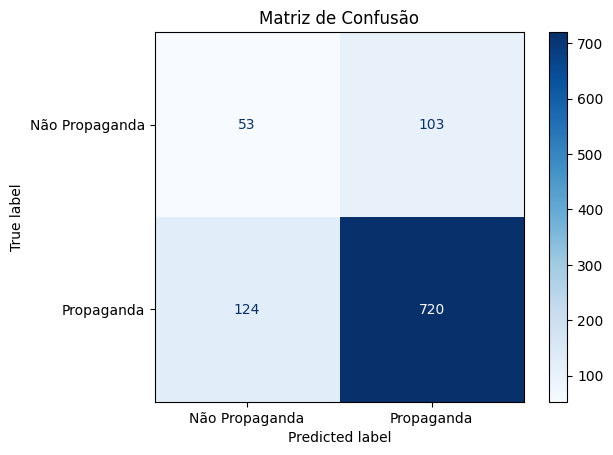

In [ ]:
#@markdown  Matriz de Confusão:
gerar_matriz_confusao = True #@param {type:"boolean"}

def matriz_confusao(y_true, y_pred):
  # Calcular a matriz de confusão
  cm = confusion_matrix(y_true, y_pred)

  # Exibir a matriz de confusão
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Propaganda', 'Propaganda'])
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Matriz de Confusão')
  plt.show()

if gerar_matriz_confusao:
  matriz_confusao(y_teste, y_pred)

In [ ]:
arred = 5
# Calcular a Acurácia:
acuracia = round(accuracy_score(y_teste, y_pred), arred)

# Calcular a Precisão:
precisao = round(precision_score(y_teste, y_pred), arred)

# Calcular o Recall:
recall = round(recall_score(y_teste, y_pred), arred)

# Calcular o F1-Score:
f1 = round(f1_score(y_teste, y_pred), arred)

# Exibir as métricas
print("Acurácia:", acuracia)
print("Precisão:", precisao)
print("Recall:", recall)
print("F1-Score:", f1)

Acurácia: 0.773
Precisão: 0.87485
Recall: 0.85308
F1-Score: 0.86383


In [ ]:
mc

array([[ 53, 103],
       [124, 720]])

In [ ]:
vp = mc[1][1]
vn = mc[0][0]
fp = mc[0][1]
fn = mc[1][0]

acuracia_manual = round((vp + vn) / (vp + vn + fp + fn),arred)
precisao_manual = round(vp / (vp + fp),arred)
recall_manual = round(vp / (vp + fn),arred)
f1_manual = round(2 * ((precisao_manual * recall_manual) / (precisao_manual + recall_manual)),arred)

print("Acurácia:", acuracia_manual)
print("Precisão:", precisao_manual)
print("Recall:", recall_manual)
print("F1-Score:", f1_manual)

Acurácia: 0.773
Precisão: 0.87485
Recall: 0.85308
F1-Score: 0.86383


'\nn_estimators = 100\nAcurácia: 0.824\nPrecisão: 0.86784\nRecall: 0.93365\nF1-Score: 0.89954\n\nn_estimators = 500\nAcurácia: 0.823\nPrecisão: 0.86608\nRecall: 0.93483\nF1-Score: 0.89914\n\nn_estimators = 1000\nAcurácia: 0.824\nPrecisão: 0.86543\nRecall: 0.9372\nF1-Score: 0.89989\n'

In [ ]:
print(f'Modelo: {modelo}')
print(f'Classificação: {classificacao}')
print(f'Balanceamento: {balanceamento}')

Modelo: Decision Tree
Classificação: Simples
Balanceamento: Oversampling


### **Exportar Resultados**

In [ ]:
# Inserir caminho de saída:
output_path = ''

# Dia e hora do experimento:
fuso_horario_brasil = pytz.timezone('America/Sao_Paulo') # Fuso horário do Brasil
current_time = datetime.now(fuso_horario_brasil).strftime("%d%m%Y_%H%M")

In [ ]:
# Gerando DataFrame de resultados:
if len(features) < 15000:
  df_resultados = pd.DataFrame(index=range(11), columns=range(len(features)))
else:
  df_resultados = pd.DataFrame(index=range(11), columns=range(10))

# Inserindo features no df de resultados:
try:
  if max_features is None:
    df_resultados.at[0,0] = 'Limite Excedido'
  else:
    for feature in range(len(features)):
      df_resultados.at[0, feature] = features[feature]
except:
  for feature in range(len(features)):
    df_resultados.at[0, feature] = features[feature]

# Inserindo total de features:
df_resultados.at[1,0] = len(features)

# Inserindo classificação:
if classificacao == 'Simples':
  df_resultados.at[2,0] = 'Classificação Simples'
else:
  df_resultados.at[2,0] = 'Classificação Multirrótulo'

# Inserindo modelo:
df_resultados.at[3,0] = modelo

# Inserindo balanceamento:
df_resultados.at[4,0] = balanceamento

# Inserindo Acurácia:
df_resultados.at[5,0] = acuracia

# Inserindo Precisão:
df_resultados.at[6,0] = precisao

# Inserindo Recall:
df_resultados.at[7,0] = recall

# Inserindo F1-Score:
df_resultados.at[8,0] = f1

# TF-IDF:
if tf_idf:
  df_resultados.at[9,0] = f'Aplica: n-gramas = {n_gramas}; max_features = {max_features}'
else:
  df_resultados.at[9,0] = 'Não Aplica'

# P-valor e limite de features:
if modelo == 'Regressao Logistica':
  if filtrar_features:
    df_resultados.at[10,0] = f'{pvalor} ({tot_features_removidas} features removidas)'
  else:
    df_resultados.at[10,0] = 'Não Aplicável'
else:
  df_resultados.at[10,0] = 'Não Aplicável'

# Inserindo dia e hora do experimento:
df_resultados.at[11,0] = current_time

# Nomeando índices:
indices_resultados = ['Features', 'Total de Features', 'Tipo de Classificação', 'Modelo', 'Balanceamento da Base',
                      'Acurácia', 'Precisão', 'Recall', 'F1-Score', 'TF-IDF', 'P-valor', 'Dia e Hora']
df_resultados.index = indices_resultados

display(df_resultados)

,0,1,2,3,4,5,6,7,8
Features,total_frases,media_caracteres_por_frase,variancia_caracteres_por_frase,total_caracteres,media_caracteres_por_palavra,variancia_caracteres_por_palavra,frequencia_pontuacao,frequencia_letras_maiusculas,prop_token_palavras_lematizadas
Total de Features,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tipo de Classificação,Classificação Simples,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Modelo,Decision Tree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Balanceamento da Base,Oversampling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Acurácia,0.773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Precisão,0.87485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Recall,0.85308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1-Score,0.86383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TF-IDF,Não Aplica,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_matriz_confusao = pd.DataFrame(index=range(2), columns=range(2))

df_matriz_confusao.at[0,0] = f'{mc[0][0]} (VN)'
df_matriz_confusao.at[0,1] = f'{mc[0][1]} (FP)'
df_matriz_confusao.at[1,0] = f'{mc[1][0]} (FN)'
df_matriz_confusao.at[1,1] = f'{mc[1][1]} (VP)'

# Nomeando índices:
indices_matriz = ['Não-Propaganda', 'Propaganda']
df_matriz_confusao.index = indices_matriz
df_matriz_confusao.columns = indices_matriz

display(df_matriz_confusao)

,Não-Propaganda,Propaganda
Não-Propaganda,53 (VN),103 (FP)
Propaganda,124 (FN),720 (VP)


In [ ]:
# Gerando arquivo Excel:
try:
  if filtrar_features:
    output_file = f'{output_path}Resultados - {classificacao} - {modelo} - {balanceamento} - {len(features)}features - {current_time} - p-valor {pvalor}.xlsx'
  else:
    output_file = f'{output_path}Resultados - {classificacao} - {modelo} - {balanceamento} - {len(features)}features - {current_time}.xlsx'
except:
  output_file = f'{output_path}Resultados - {classificacao} - {modelo} - {balanceamento} - {len(features)}features - {current_time}.xlsx'

writer = pd.ExcelWriter(output_file, engine='xlsxwriter')
df_resultados.to_excel(writer, sheet_name='Resultados', index=True, header=False)
df_matriz_confusao.to_excel(writer, sheet_name='Matriz de Confusão', index=True, header=True)

# Ajustar a largura da primeira coluna da aba 'Resultados' automaticamente:
worksheet = writer.sheets['Resultados']
index_col_width = max(len(str(index)) for index in df_resultados.index) + 2
worksheet.set_column(0, 0, index_col_width)

# Ajustar a largura da primeira coluna da aba 'Matriz de Confusão' automaticamente:
worksheet = writer.sheets['Matriz de Confusão']
index_col_width = max(len(str(index)) for index in df_matriz_confusao.index) + 2
worksheet.set_column(0, 0, index_col_width)

# Ajustar a largura das outras colunas da aba 'Matriz de Confusão' automaticamente:
for i, col in enumerate(df_matriz_confusao.columns):
    col_width = max(df_matriz_confusao[col].astype(str).str.len().max(), len(col)) + 2
    worksheet.set_column(i + 1, i + 1, col_width)

#writer.save()
writer.close()

# Formatar cores Excel:
wb = load_workbook(output_file)
wr = wb['Resultados']
wmc = wb['Matriz de Confusão']

# Pintar células da aba 'Resultados':
fill_r = PatternFill(start_color="54D8EF", end_color="54D8EF", fill_type="solid")
wr['A1'].fill = fill_r
wr['A2'].fill = fill_r
wr['A3'].fill = fill_r
wr['A4'].fill = fill_r
wr['A5'].fill = fill_r
wr['A6'].fill = fill_r
wr['A7'].fill = fill_r
wr['A8'].fill = fill_r
wr['A9'].fill = fill_r
wr['A10'].fill = fill_r
wr['A11'].fill = fill_r
wr['A12'].fill = fill_r
fill_met = PatternFill(start_color="F3FA6C", end_color="F3FA6C", fill_type="solid")
wr['B6'].fill = fill_met
wr['B7'].fill = fill_met
wr['B8'].fill = fill_met
wr['B9'].fill = fill_met

# Pintar células da aba 'Matriz de Confusão':
fill_mc_positivo = PatternFill(start_color="18E547", end_color="18E547", fill_type="solid")
wmc['B2'].fill = fill_mc_positivo
wmc['C3'].fill = fill_mc_positivo
fill_mc_negativo = PatternFill(start_color="F7512C", end_color="F7512C", fill_type="solid")
wmc['C2'].fill = fill_mc_negativo
wmc['B3'].fill = fill_mc_negativo

# Salvar as alterações no arquivo Excel
wb.save(output_file)

In [ ]:
print(f'{output_path}Resultados - {classificacao} - {modelo} - {balanceamento} - {len(features)}features - {current_time}')

Resultados - Simples - Decision Tree - Oversampling - 9features - 16062024_2155


In [ ]:
try:
  del max_features
except:
  pass

In [ ]:
##########################################################################################################################################################

### **Importância dos Atributos da Árvore de Decisão**

In [ ]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    paths = []
    path = []

    def recurse(node, path, paths):

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]

    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]

    rules = []
    for path in paths:
        rule = "if "

        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]

    return rules

In [ ]:
rules = get_rules(clf, list(X_train.columns), ['Não-persuasivo', 'Persuasivo'])
for r in rules:
    print(r)

if (total_caracteres > 70.5) and (total_caracteres > 110.5) and (variancia_caracteres_por_palavra > 1.349) and (media_caracteres_por_frase > 27.829) and (frequencia_pontuacao > 2.5) and (media_caracteres_por_palavra > 4.005) and (prop_token_palavras_lematizadas > 0.489) and (variancia_caracteres_por_frase <= 51948.834) and (frequencia_pontuacao <= 9.5) and (media_caracteres_por_palavra <= 5.544) and (frequencia_letras_maiusculas > 6.5) and (variancia_caracteres_por_palavra <= 7.933) and (total_caracteres > 112.5) and (frequencia_pontuacao > 3.5) and (total_caracteres > 125.5) then class: Persuasivo (proba: 100.0%) | based on 525 samples
if (total_caracteres > 70.5) and (total_caracteres > 110.5) and (variancia_caracteres_por_palavra > 1.349) and (media_caracteres_por_frase > 27.829) and (frequencia_pontuacao > 2.5) and (media_caracteres_por_palavra > 4.005) and (prop_token_palavras_lematizadas > 0.489) and (variancia_caracteres_por_frase <= 51948.834) and (frequencia_pontuacao > 9.5) a

In [ ]:
qtd_regras = []
for r in rules:
  qtd_regras.append(len(r.split('and ')))

In [ ]:
min(qtd_regras)

3

In [ ]:
len(X_train)

11472

In [ ]:
df.describe().to_excel('estatisticas_base_completa.xlsx', sheet_name='Resultados', index=True, header=True)

In [ ]:
df[df['propaganda'] == 0].describe().to_excel('estatisticas_nao_persuasivo.xlsx', sheet_name='Resultados', index=True, header=True)
df[df['propaganda'] == 1].describe().to_excel('estatisticas_persuasivo.xlsx', sheet_name='Resultados', index=True, header=True)

In [ ]:
df[df['propaganda'] == 1].describe()

,id,propaganda,total_frases,media_caracteres_por_frase,variancia_caracteres_por_frase,total_caracteres,media_caracteres_por_palavra,variancia_caracteres_por_palavra,frequencia_pontuacao,frequencia_letras_maiusculas,prop_token_palavras_lematizadas
count,5736.000000,5736.0,5736.000000,5736.000000,5736.000000,5736.000000,5736.000000,5736.000000,5736.000000,5736.000000,5736.000000
mean,70386.611402,1.0,1.716353,80.797265,665.043966,124.899582,4.730803,5.272571,4.145921,41.998954,0.883366
std,5268.627797,0.0,1.331629,57.944407,2715.546799,108.383964,0.904760,2.905535,4.752072,49.593113,0.120630
min,63100.000000,1.0,1.000000,4.000000,0.000000,4.000000,2.666667,0.000000,0.000000,0.000000,0.090909
25%,65975.750000,1.0,1.000000,43.500000,0.000000,61.000000,4.181818,3.400661,1.000000,7.000000,0.817862
50%,69266.500000,1.0,1.000000,67.500000,0.000000,94.000000,4.625000,4.906486,3.000000,25.000000,0.909091
75%,76406.250000,1.0,2.000000,100.000000,225.000000,151.000000,5.133333,6.687500,6.000000,61.000000,1.000000
max,79930.000000,1.0,18.000000,838.000000,105625.000000,1511.000000,26.500000,33.246537,59.000000,769.000000,1.000000


In [ ]:
for r in rules:
  if len(r.split('and')) == min(qtd_regras):
    print(r)

if (total_caracteres > 70.5) and (total_caracteres > 110.5) and (variancia_caracteres_por_palavra <= 1.349) then class: Não-persuasivo (proba: 100.0%) | based on 11 samples


In [ ]:
for r in rules:
  if len(r.split('and')) == 6:
    print(r)

In [ ]:
len(rules[0].split('and'))

15

In [ ]:
rules[0]

'if (total_caracteres > 70.5) and (total_caracteres > 110.5) and (variancia_caracteres_por_palavra > 1.349) and (media_caracteres_por_frase > 27.829) and (frequencia_pontuacao > 2.5) and (media_caracteres_por_palavra > 4.005) and (prop_token_palavras_lematizadas > 0.489) and (variancia_caracteres_por_frase <= 51948.834) and (frequencia_pontuacao <= 9.5) and (media_caracteres_por_palavra <= 5.544) and (frequencia_letras_maiusculas > 6.5) and (variancia_caracteres_por_palavra <= 7.933) and (total_caracteres > 112.5) and (frequencia_pontuacao > 3.5) and (total_caracteres > 125.5) then class: Persuasivo (proba: 100.0%) | based on 525 samples'